In [1]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [10]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.0 MB/s eta 0:00:00


In [11]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
local_zip = 'Alzheimer_s_Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp')
zip_ref.close()
%ls ./tmp/Alzheimer_s_Dataset/

test/  train/


In [4]:
BATCH_SIZE = 32
# IMAGE_SIZE = [176,208]
IMAGE_WIDTH = 176
IMAGE_HEIGHT = 208

CHANNELS=3
EPOCHS=50

In [15]:
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/train/",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/train/",
    validation_split=0.2,
    subset="validation",
    shuffle=False,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)

test_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "./tmp/Alzheimer_s_Dataset/test/",
    shuffle=False,
    seed=1337,
    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=BATCH_SIZE
)


Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


In [16]:
class_names = train_ds.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [17]:
NUM_CLASSES = len(class_names)
print('number of classes: ',NUM_CLASSES)

number of classes:  4


In [18]:
NUM_IMAGES = {}
for label in class_names:
    dir_name = "./tmp/Alzheimer_s_Dataset/train/" + label[:-2] + 'ed'
    # print(dir_name)
    # print(label[:-2] + 'ed')
    NUM_IMAGES.update({label[:-2] + 'ed' : len([name for name in os.listdir(dir_name)])})
print('Number of images in each class',NUM_IMAGES)

Number of images in each class {'MildDemented': 717, 'ModerateDemented': 52, 'NonDemented': 2560, 'VeryMildDemented': 1792}


In [19]:
## Calculate class weights.

total = sum(NUM_IMAGES.values())
number_of_classes = len(NUM_IMAGES)
print('total images',total)
print('no of images',number_of_classes)

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(NUM_IMAGES.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

total images 5121
no of images 4
Weight for class "MildDemented" : 1.79
Weight for class "ModerateDemented" : 24.62
Weight for class "NonDemented" : 0.5
Weight for class "VeryMildDemented" : 0.71


In [20]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomZoom(height_factor=(0.05), width_factor=(0.05)),
    layers.RandomRotation(factor=0.1),
    layers.RandomContrast(factor=0.1),
    layers.RandomCrop(150,150),

    # layers.experimental.preprocessing.Rescaling(1./255),
])


In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [23]:
def random_cut_out(images, labels):

    images=tfa.image.random_cutout(images, (10,10), constant_values = 5)
    return images,labels
    # images=tfa.image.angles_to_projective_transforms(angles=tf.cast(tf.constant(np.pi/8) ,tf.float32),image_width=tf.cast(tf.constant(176),tf.float32)
    # ,image_height=tf.cast(tf.constant(208),tf.float32))




In [24]:
train_ds = train_ds.map(random_cut_out)


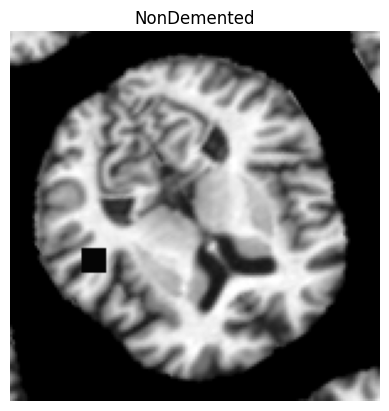

In [25]:
for image_batch, labels_batch in train_ds.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[labels_batch[0]])
  plt.axis('off')

In [26]:
# resize_and_rescale = tf.keras.Sequential([
#   layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
#   layers.experimental.preprocessing.Rescaling(1./255),
# ])

def preprocess(images,label):
  images = tf.image.resize(images, (150,150))
  # images = tf.cast(images/255. ,tf.float32)

  return images,label


In [27]:
train_ds = train_ds.cache().map(preprocess).shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().map(preprocess).prefetch(buffer_size=tf.data.AUTOTUNE)


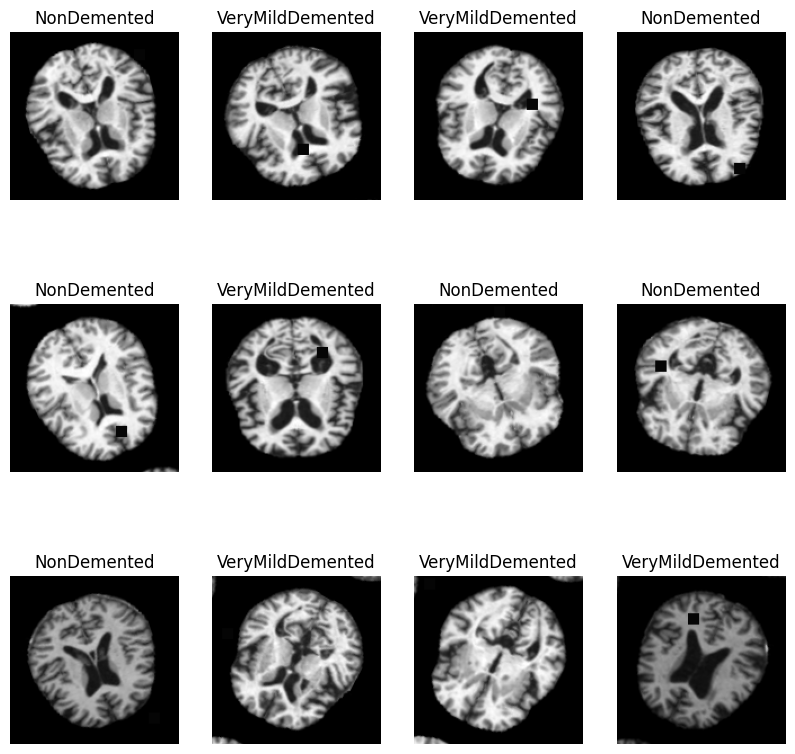

In [28]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):

    for i in range(12):

        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")